# The Erying Equation and Experimental Error
The famous Erying equationis used to create a linear equation that relates the free energy of activation or the free energy in an equilibrium with temperature. Because the enthalpy term is independant of temperature and the entropy term involves temperature, we can the separate these effects and determine the enthalpy and the entropy difference in the chemical change between reactants and transtion state or products. But, do you numbers make sense? Unless you are calculating the standard deviations from your plot you may be unaware of a low quality relationship.

## Enzyme Kinetics Example

The data sets for this experiment comes from "Linear Eyring Plots Conceal a Change in the Rate-Limiting Step in an Enzyme Reaction", Teresa F. G. Machado, Tracey M. Gloster, and Rafael G. da Silva, *Biochemistry*, **2018**, *57*, 6757-6761.https://doi.org/10.1021/acs.biochem.8b01099.

Machado et al. were presenting an example where they hypothesized that there was a hidden effect due to changes in the rate-determining step. The plots are very linear so we will use the data at face value. I'm not really convinced that there was a change in rds.

The reaction is the reduction of acetoacetate (3-oxobutanoate) or 3-Oxopentanoate by NADH with the action of *(R)-3-hydroxybutyrate dehydrogenase* (EC 1.1.1.30). Two sources of the enzyme were used. The common bacteria *Acinetobacter baumannii* and the cold-favouring (psychrophilic) bacteria *Psychrobacter arcticus*. The Michaelis-Menten turnover number ($k_{cat}$, the first-order rate constant of the enzyme-NADH-substrate complex to give product) was measured at temperatures for $-10$ to $67\ ^\circ C$. The Eyring plot for the *P. arcticus* curves slightly as temperature increases. The enzyme comes from an organism adapted got cold conditions. The plot for the *A. baumannii* enzyme were linear so I will only use that data in this example.


## The Eyring Equation

The Erying equation is...

$$ k = \frac{\kappa k_B}{h} T e^{-\Delta G^\ddagger}$$

...and we can include that $\Delta G^\ddagger = \Delta H^\ddagger - T \Delta S^\ddagger$ and we obtain...

$$ k = \frac{\kappa k_B}{h} T e^{\frac{-\Delta H^\ddagger}{RT}}e^{\frac{\Delta S^\ddagger}{R}}$$

This can be written in a linear form...

$$\ln \frac{k}{T} = \frac{-\Delta H^\ddagger}{R}\cdot\frac{1}{T} + \ln\frac{\kappa k_B}{h} + \frac{\Delta S^\ddagger}{R}$$

...where $k$ is the observed rate constant and $T$ is the absolute temperature.

From this, we can find $\Delta H^\ddagger$ and $\Delta S^\ddagger$ from the slope and intercept by plotting $\ln \frac{k}{T}$ vs. $\frac{1}{T}$

## Choose Your Data

In the code below we call the packages and define clobal variables. One important variable is the name of the data file. The following data files are available.

> Eryingdata1.csv - *AbHBDH* with 3-oxobutyrate <br>
Eryingdata2.csv - *AbHBDH* with 3-oxopentanoate

change the datafile variable to repeat this notebook with the other data set. There are several more data sets from two other recent contributions that are described at the end of this document. Try them and see what the effect of more or less data has on you error for calculating the parameters of the Eyring plot

In [148]:
### Setup packagaes and global variables

from scipy.optimize import curve_fit     ## tool for curve fitting
import scipy                             ## tools for science
import numpy as np                       ## import the tools of NumPy but use a shorter name
import pandas as pd                      ## import tools for data handling
from matplotlib import pyplot as plt     ## tools for plotting

import uncertainties as un               ## tool set for handling numbers with uncertainties
from uncertainties import unumpy as unp  ## a replacement for numpy that uses uncertainty values
from uncertainties import umath as um    ## a replacement for math that uses uncertainty values

github_location = "./"                   ## Use either local folde or github folder. use github locations for Colab
github_location_styles = "./"
#github_location = "https://raw.githubusercontent.com/blinkletter/3530Biochem/main/data/"
#github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"

datafile = "data/EryingData1.csv"   # change this file for new data
#datafile = "data/EryingData2.csv"  
#datafile = "data/EryingDataC1.csv"  # see bottom of notebook for more info


In [149]:
### Inspect the data file

with open(datafile, 'r') as file:
    file_content = file.read()  # Read the content of the file
    print(file_content)         # Print the content

# from "Linear Eyring Plots Conceal a Change in the Rate-Limiting Step in an Enzyme Reaction"
# Teresa F. G. Machado, Tracey M. Gloster, and Rafael G. da Silva
# Biochemistry 2018 57 (49), 6757-6761
# https://doi.org/10.1021/acs.biochem.8b01099
#
# data for Figure 1: AbHBDH with Acetoacetate 
"TEMP(K)", "Kcat(s-1)", "Error(s-1)"
283,     3.4,      0.1  
288,     5.3,      0.2  
293,     7.6,      0.2   
298,     11.7,     0.3 
303,     15.2,     0.1 
308,     21.3,     0.9 
313,     27.8,     0.9 
318,     39,       3 
323,     52,       4 
325,     61,       2 
328,     69,       3 
330,     79,       7 


In [150]:
### Read in data set

data = pd.read_csv(datafile, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="Substituent", 
                 comment = "#") 
display(data)

,TEMP(K),Kcat(s-1),Error(s-1)
0,283,3.4,0.1
1,288,5.3,0.2
2,293,7.6,0.2
3,298,11.7,0.3
4,303,15.2,0.1
5,308,21.3,0.9
6,313,27.8,0.9
7,318,39.0,3.0
8,323,52.0,4.0
9,325,61.0,2.0


In [151]:
### Calculate values for Eyring Plot

df = data                            # set the dataframe to be the dataframe read in above

#df = data.loc[[2,4,6,8]].copy()       # slice a set of rows from the dataframe to demonstrate
                                      #   a smaller dataset and the effect on precision

#df = data.loc[6:11].copy()             # slice consecutive rows



df["k_unc"] = unp.uarray(df["Kcat(s-1)"],df["Error(s-1)"])   # Combine value and stdev to make Uncertainties values
df["1/T"] = 1/df["TEMP(K)"]                                  # get 1/T for x-axis
df["ln(k)/T"] = unp.log(df["k_unc"]/df["TEMP(K)"])           # get ln(k/T) for y-axis with error propagation

display(df)


,TEMP(K),Kcat(s-1),Error(s-1),k_unc,1/T,ln(k)/T
0,283,3.4,0.1,3.40+/-0.10,0.003534,-4.422+/-0.029
1,288,5.3,0.2,5.30+/-0.20,0.003472,-4.00+/-0.04
2,293,7.6,0.2,7.60+/-0.20,0.003413,-3.652+/-0.026
3,298,11.7,0.3,11.70+/-0.30,0.003356,-3.238+/-0.026
4,303,15.2,0.1,15.20+/-0.10,0.003300,-2.992+/-0.007
5,308,21.3,0.9,21.3+/-0.9,0.003247,-2.67+/-0.04
6,313,27.8,0.9,27.8+/-0.9,0.003195,-2.421+/-0.032
7,318,39.0,3.0,39.0+/-3.0,0.003145,-2.10+/-0.08
8,323,52.0,4.0,52+/-4,0.003096,-1.83+/-0.08
9,325,61.0,2.0,61.0+/-2.0,0.003077,-1.673+/-0.033


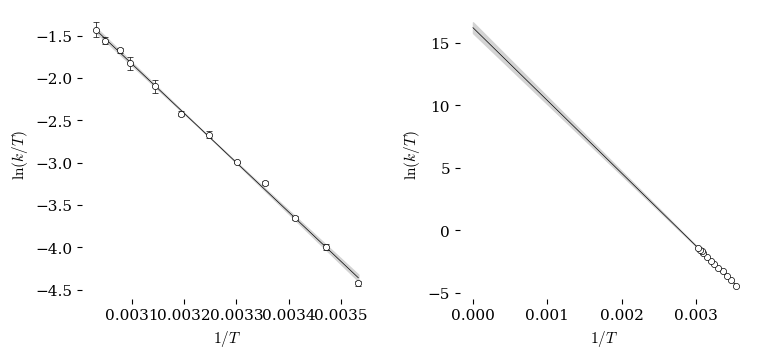

The slope is -5826.55 +/- 66.47
The intercept is 16.229 +/- 0.2158
The RSQ is 0.999


In [152]:
### Choose our x and y values.

x = df["1/T"]
y = unp.nominal_values(df["ln(k)/T"])
y_err = unp.std_devs(df["ln(k)/T"])

nstd = 2.     # Number of sigmas for confidence interval 1 = 68%, 2 = 95%, 3 = 99.7% confidence

### Curve fit to linear function

def linear(x, slope, intercept):
    return slope * x + intercept

popt,pcov = curve_fit(linear, x, y, 
          #             sigma = y_err, absolute_sigma=False  # Include st_devs for y data in calculations
                     )

[slope,intercept] = popt
perr = np.sqrt(np.diag(pcov))

### Create figure for plot
plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

size = [8,4]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=size)  

### Create plot #0 for plot

# Settings for plot
ax[0].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
#          ylim=[None,None]
       )

# Plot the data
#ax[0].scatter(x, y, marker = "o", s = 70, color = "white", alpha = 1.0, zorder = 1)
ax[0].scatter(x, y, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3) 

# Add error bars
ax[0].errorbar(x, y, yerr=y_err, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
               capsize=2, capthick=0.5, zorder=2)

# Calculate the line from curve fit parameters
x_fit = np.linspace(np.min(x), np.max(x), 100)
#x_fit = np.linspace(0, np.max(x), 100)
y_fit = linear(x_fit,slope,intercept)

# Plot the curve fit line
ax[0].plot(x_fit, y_fit, 
           marker = None, color = "black", 
           linewidth=0.5, zorder = 2)

# prepare confidence level curves
popt_plus = popt + nstd * perr    # add error to parameters
popt_minus = popt - nstd * perr   # subtract error from paramneters

# steeper slope will result in higher intercept and vice versa
confidence_line_1 = linear(x=x_fit, slope=popt_plus[0], intercept=popt_minus[1])
confidence_line_2 = linear(x=x_fit, slope=popt_minus[0], intercept=popt_plus[1])

# Plot confidence interval
ax[0].fill_between(x_fit, confidence_line_1, confidence_line_2, 
                   color="lightgray", alpha=1, zorder = 0,
                   label="confidence interval")

### Create plot #1 for plot

# Settings for plot
ax[1].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
#          ylim=[None,None]
       )

# Plot the data
#ax[1].scatter(x, y, marker = "o", s = 70, color = "white", zorder = 1)
ax[1].scatter(x, y, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3) 

# Add error bars
#ax[1].errorbar(x, y, yerr=y_err, xerr=None, fmt="None", ecolor="black", elinewidth=0.5, capsize=2, capthick=0.5, zorder=1)

# Calculate the line from curve fit parameters
x_fit = np.linspace(0, np.max(x), 100)
y_fit = linear(x_fit,slope,intercept)

# Plot the curve fit line
ax[1].plot(x_fit, y_fit, marker = None, 
           color = "black", linewidth=0.5, zorder = 2)

# prepare confidence level curves
popt_plus = popt + nstd * perr    # add error to parameters
popt_minus = popt - nstd * perr   # subtract error from paramneters

# steeper slope will result in higher intercept and vice versa
confidence_line_1 = linear(x=x_fit, slope=popt_plus[0], intercept=popt_minus[1])
confidence_line_2 = linear(x=x_fit, slope=popt_minus[0], intercept=popt_plus[1])

# Plot confidence interval
ax[1].fill_between(x_fit, confidence_line_1, confidence_line_2, 
                   color = "lightgray", alpha=1, zorder = 0,
                   label="confidence interval")


#ax[0].set_xticks([0.0032,0.0033,0.0034])

### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("Eyring_L.pdf")
plt.show()

print(f"The slope is {slope:0.2f} +/- {perr[0]:0.2f}")
print(f"The intercept is {intercept:0.3f} +/- {perr[1]:0.4f}")

r, p = scipy.stats.pearsonr(x, y)
rsq = r ** 2

print(f"The RSQ is {rsq:0.3f}")



## Calculate Activation Parameters

We now have values for the slope and intercept. We can use the definitions of the slope and intercept in the Erying equation to calculate the thermodynamic parameters for the transition state.

$$\text{slope} = \frac{-\Delta H^\ddagger}{R}$$

$$ \Delta H^\ddagger = -\text{slope}\cdot R$$

and

$$\text{intercept} = \ln\frac{\kappa k_B}{h} + \frac{\Delta S^\ddagger}{R}$$


$$\Delta S^\ddagger =\left( \text{intercept} - \ln\frac{\kappa k_B}{h}\right) R $$

$\kappa$ is the transmission coefficient and is assumed to be unity in transition state theory

$k_B$ is the Boltzman constant: $1.380649\times10^{23} \ J\, K^{-1}$

$R$ is the gas constant: $8.314462618 \ J\, mol^{-1} K^{-1}$ 

$h$ is the Planck constant: $6.62607015\times10^{-34}\ J\, s$

In [153]:
R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

slope_unc = un.ufloat(slope, perr[0])
dH = -slope_unc * R
print(f"The change in enthalpy is {dH:0.2f} kJ/mole")

intercept_unc = un.ufloat(intercept, perr[1])
dS = (intercept_unc - np.log(kb/h)) * R
print(f"The change in entropy is {dS:0.2f} J/mole.K")


The change in enthalpy is 48444.61+/-552.67 kJ/mole
The change in entropy is -62.61+/-1.79 J/mole.K


In [154]:
## calculate k from Erying plot parameters.

Temp = 325

kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)

print(f"calculate k at T={Temp} K is {kobs:0.2f}")


calculate k at T=325 K is 59.46+/-17.68


# Using Bootstrap Analysis

I have used the Seaborn plotting package to visualize confidence intervals using the ```regplot()``` function. But I want to use the bootstrap analysis performed by regplot directly. Below is code that accomplishes this goal.

<Axes: xlabel='1/T'>

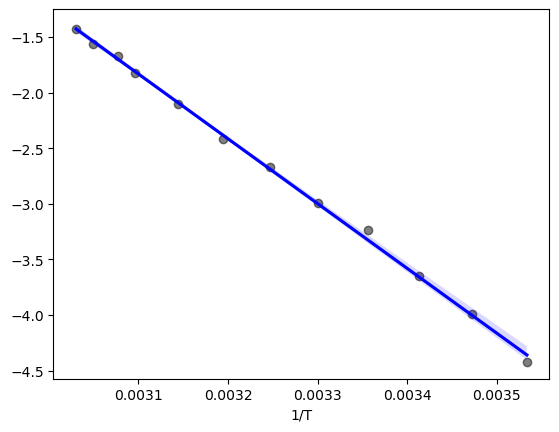

In [155]:
import seaborn as sns
plt.rcdefaults()

x = df["1/T"]
y = unp.nominal_values(df["ln(k)/T"])

sns.regplot(x = x, y = y,
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "blue"}, 
            ci = 95) # 99% level

Confidence level = 66%

slope range is -5738.3 to -5932.5
median slope in bootstrap population is -5852.2 + 114.0 - 80.3
best fit value for slope is -5857.9  +/- 89.3

intercept range is 16.58 to 15.95
median intercept in bootstrap population is 16.32 + 0.26 - 0.37
best fit value for intercept is 16.34 +/- 0.29



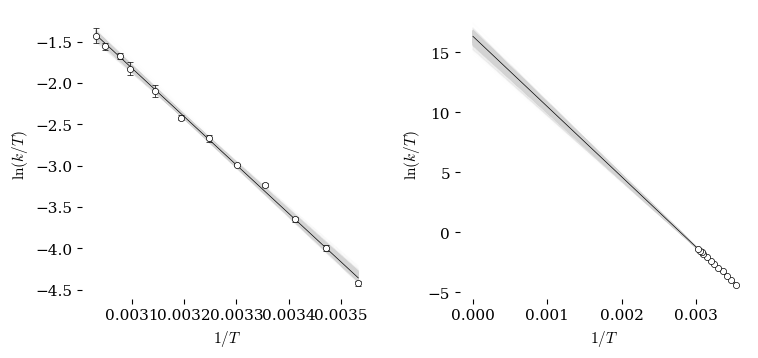

In [156]:
## THIS IS MY VERSION
## Adapted from code found in https://stats.stackexchange.com/questions/183230/bootstrapping-confidence-interval-from-a-regression-prediction

conf = 66

x = np.array(df["1/T"])
y = unp.nominal_values(df["ln(k)/T"])
y_err = unp.std_devs(df["ln(k)/T"])

def linear(x, slope, intercept):
    return slope * x + intercept

### Create figure for plot
plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

size = [8,4]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=size)  

ax[0].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
#          ylim=[None,None]
         )
ax[1].set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T$",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
#          ylim=[None,None]
         )
## Plot in range of data

slope_list = []
intercept_list = []

for i in range(0, 2000):
    sample_index = np.random.choice(range(0, len(y)), len(y))

    x_samples = x[sample_index]
    y_samples = y[sample_index] 
    y_err_samples = y_err[sample_index]

    popt,pcov = curve_fit(linear, x_samples, y_samples, 
                          sigma = y_err_samples, absolute_sigma=False  # Include st_devs for y data in calculations
                     )
    [slope,intercept] = popt
    slope_list.append(slope)
    intercept_list.append(intercept)

    xb = np.insert(x,0,0)   # insert zero into first position of x data so line fit starts from zero

    ax[0].plot(x, linear(x, slope, intercept), color='lightgrey', linewidth = 0.5, alpha=.01, zorder=1)
    ax[1].plot(xb, linear(xb, slope, intercept), color='lightgrey', linewidth = 0.5, alpha=.01, zorder=1)
    
xa = np.array(x)    # I plan to use some numpy functions on these data series so converts from

popt,pcov = curve_fit(linear, x, y, 
                      sigma = y_err, absolute_sigma=False  # Include st_devs for y data in calculations
                     )

[slope,intercept] = popt
perr = np.sqrt(np.diag(pcov))


ax[0].scatter(x,y, marker='o', color='white', s = 20, edgecolor='black', linewidth = 0.5, zorder=5)
ax[1].scatter(x,y, marker='o', color='white', s = 20, edgecolor='black', linewidth = 0.5, zorder=5)

ax[0].errorbar(x, y, yerr=y_err, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
               capsize=2, capthick=0.5, zorder=2)


low_p = 50 - conf/2
high_p = 50 + conf/2

top_slope = np.percentile(slope_list, high_p)
bot_slope = np.percentile(slope_list, low_p)
median_slope = np.percentile(slope_list, 50)

print(f"Confidence level = {conf}%")
print()

print(f"slope range is {top_slope:0.1f} to {bot_slope:0.1f}")
print(f"median slope in bootstrap population is {median_slope:0.1f} + {top_slope-median_slope:0.1f} - {median_slope-bot_slope:0.1f}")
print(f"best fit value for slope is {slope:0.1f}  +/- {perr[0]:0.1f}")
print()

top_intercept = np.percentile(intercept_list, high_p)
bot_intercept = np.percentile(intercept_list, low_p)
median_intercept = np.percentile(intercept_list, 50)

print(f"intercept range is {top_intercept:0.2f} to {bot_intercept:0.2f}")
print(f"median intercept in bootstrap population is {median_intercept:0.2f} + {top_intercept-median_intercept:0.2f} - {median_intercept-bot_intercept:0.2f}")
print(f"best fit value for intercept is {intercept:0.2f} +/- {perr[1]:0.2f}")
print()


xb = np.insert(xa,0,0)   # insert zero into first position of x data so line fit starts from zero

#ax[0].plot(xa, linear(xa, slope, intercept), color='red', linewidth = 0.5, zorder=4)
ax[0].plot(xa, linear(xa, median_slope, median_intercept), color='black', linewidth = 0.5, zorder=4)

#ax[1].plot(xb, linear(xb, slope, intercept), color='red', linewidth = 0.5, zorder=4)
ax[1].plot(xb, linear(xb, median_slope, median_intercept), color='black', linewidth = 0.5, zorder=4)

### Change x and y ticks

#ax[0].set_xticks([0.0031,0.0033,0.0035])
#ax[0].locator_params(axis='x', nbins=3)
#ax[0].set_yticks([-1,-2,-3,-4,-5])
#ax[0].locator_params(axis='y', nbins=6)

#ax[1].set_xticks([0.000,0.001,0.002,0.003,0.004])
#ax[1].locator_params(axis='x', nbins=3)
#ax[1].set_yticks([-5,0,5,10,15,20])
#ax[1].locator_params(axis='y', nbins=5)


### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("Eyring_bootstrap_L.pdf")
plt.show()


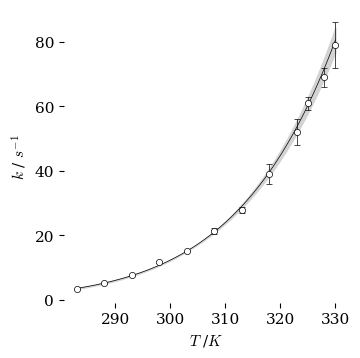

The dH is 48.76 +/- 0.72 kJ/mole
The dS is -61.514 +/- 2.3705 J/(mole.K)
The RSQ is 0.903


In [157]:
x = df["TEMP(K)"]
y = df["Kcat(s-1)"]
y_err = df["Error(s-1)"]
#plt.plot(x,y,"ko")

nstd = 2.     # Number of sigmas for confidence interval 1 = 68%, 2 = 95%, 3 = 99.7% confidence

### Curve fit to linear function

def eyring(T, dH, dS):
    
    R = scipy.constants.R
    kb = scipy.constants.k
    h = scipy.constants.h
    kappa = 1

    #kobs = (kappa * kb * T / h) * np.exp(dS/R) * np.exp(-dH/(R*T))

    return (kappa * kb / h) * T * np.exp(-dH/(R*T)) * np.exp(dS/R)


popt,pcov = curve_fit(eyring, x, y, 
                      sigma = y_err, absolute_sigma=False,  # Include st_devs for y data in calculations
                     #p0 = [50000,-50]
                     )

[dH,dS] = popt
perr = np.sqrt(np.diag(pcov))

### Create figure for plot
plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

size = [4,4]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=size)  

### Create plot #0 for plot

# Settings for plot
ax.set(
#          title = Title,       
          ylabel=r"$k$ / $s^{-1}$", 
          xlabel=r"$T$ /$K$",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
#          ylim=[None,None]
       )

# Plot the data
#ax.scatter(x, y, marker = "o", s = 70, color = "white", alpha = 1.0, zorder = 1)
ax.scatter(x, y, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3) 

# Add error bars
ax.errorbar(x, y, yerr=y_err, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
               capsize=2, capthick=0.5, zorder=2)

# Calculate the line from curve fit parameters
x_fit = np.linspace(np.min(x), np.max(x), 100)
y_fit = eyring(x_fit,dH,dS)

# Plot the curve fit line
ax.plot(x_fit, y_fit, 
           marker = None, color = "black", 
           linewidth=0.5, zorder = 2)

# prepare confidence level curves
popt_plus = popt + nstd * perr    # add error to parameters
popt_minus = popt - nstd * perr   # subtract error from paramneters

# steeper slope will result in higher intercept and vice versa
confidence_line_1 = eyring(T=x_fit, dH=popt_plus[0], dS=popt_plus[1])
confidence_line_2 = eyring(T=x_fit, dH=popt_minus[0], dS=popt_minus[1])

# Plot confidence interval
ax.fill_between(x_fit, confidence_line_1, confidence_line_2, 
                   color="lightgray", alpha=1, zorder = 0,
                   label="confidence interval")

### Create plot #1 for plot


### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("Eyring.pdf")
plt.show()

print(f"The dH is {dH/1000:0.2f} +/- {perr[0]/1000:0.2f} kJ/mole")
print(f"The dS is {dS:0.3f} +/- {perr[1]:0.4f} J/(mole.K)")

r, p = scipy.stats.pearsonr(x, y)
rsq = r ** 2

print(f"The RSQ is {rsq:0.3f}")


Confidence level = 66%

dH range is 49336.8 to 47741.5
median dH in bootstrap population is 48699.6 + 637.3 - 958.0

dS range is -59.6 to -64.86
median dS in bootstrap population is -61.74 + 2.1 - 3.1

best fit value for dH is 48761.1  +/- 717.5
best fit value for dS is -61.51 +/- 2.37
The RSQ is 0.903


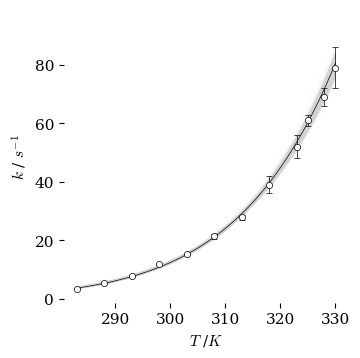

In [158]:
## THIS IS MY VERSION
## Adapted from code found in https://stats.stackexchange.com/questions/183230/bootstrapping-confidence-interval-from-a-regression-prediction

conf = 66   ### global varibale for confidence range

### Pandas series need to be converted to arrays to remove the pandas index
x = np.array(df["TEMP(K)"])            # Pandas series to NumPy array
y = np.array(df["Kcat(s-1)"])            # Pandas series to NumPy array
y_err = np.array(df["Error(s-1)"])


### Function to curve fit
def eyring(T, dH, dS):
    
    R = scipy.constants.R
    kb = scipy.constants.k
    h = scipy.constants.h
    kappa = 1

    #kobs = (kappa * kb * T / h) * np.exp(dS/R) * np.exp(-dH/(R*T))

    return (kappa * kb / h) * T * np.exp(-dH/(R*T)) * np.exp(dS/R)


### Create figure for plot
plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

size = [4,4]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=size)  

ax.set(
#          title = Title,       
          ylabel=r"$k$ / $s^{-1}$", 
          xlabel=r"$T$ /$K$",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
#          ylim=[None,None]
         )
         
## Plot in range of data

dH_list = []
dS_list = []
y_fit_list = []             # list to store all the calculated y values from each interation.

for i in range(0, 2000):
    sample_index = np.random.choice(range(0, len(y)), len(y))

    x_samples = x[sample_index]
    y_samples = y[sample_index] 
    y_err_samples = y_err[sample_index]

    popt,pcov = curve_fit(eyring, x_samples, y_samples, 
                       sigma = y_err_samples, absolute_sigma=False  # Include st_devs for y data in calculations
                     )
    [dH,dS] = popt

    x_fit = np.linspace(np.min(x), np.max(x), 100)
    y_fit = eyring(x_fit,dH,dS)
    ax.plot(x_fit, y_fit, color='lightgrey', linewidth = 0.5, alpha=.01, zorder=1)
    
    dH_list.append(dH)
    dS_list.append(dS)
    y_fit_list.append(y_fit)


popt,pcov = curve_fit(eyring, x, y, 
                      sigma = y_err, absolute_sigma=False,  # Include st_devs for y data in calculations
                     )

[dH,dS] = popt
perr = np.sqrt(np.diag(pcov))


ax.scatter(x,y, marker='o', color='white', s = 20, edgecolor='black', linewidth = 0.5, zorder=5)

ax.errorbar(x,y, yerr=y_err, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
               capsize=2, capthick=0.5, zorder=2)


low_p = 50 - conf/2
high_p = 50 + conf/2

top_dH = np.percentile(dH_list, high_p)
bot_dH = np.percentile(dH_list, low_p)
median_dH = np.percentile(dH_list, 50)

top_dS = np.percentile(dS_list, high_p)
bot_dS = np.percentile(dS_list, low_p)
median_dS = np.percentile(dS_list, 50)

print(f"Confidence level = {conf}%")
print()

print(f"dH range is {top_dH:0.1f} to {bot_dH:0.1f}")
print(f"median dH in bootstrap population is {median_dH:0.1f} + {top_dH-median_dH:0.1f} - {median_dH-bot_dH:0.1f}")
print()

print(f"dS range is {top_dS:0.1f} to {bot_dS:0.2f}")
print(f"median dS in bootstrap population is {median_dS:0.2f} + {top_dS-median_dS:0.1f} - {median_dS-bot_dS:0.1f}")
print()

print(f"best fit value for dH is {dH:0.1f}  +/- {perr[0]:0.1f}")
print(f"best fit value for dS is {dS:0.2f} +/- {perr[1]:0.2f}")


x_fit = np.linspace(np.min(x), np.max(x), 100)
y_fit = eyring(x_fit,dH,dS)
ax.plot(x_fit, y_fit, color='black', linewidth = 0.5, zorder=4)

r, p = scipy.stats.pearsonr(x, y)
rsq = r ** 2
print(f"The RSQ is {rsq:0.3f}")

#print(x_fit)

### Change x and y ticks

#ax.set_xticks([300,310,320])
#ax.locator_params(axis='x', nbins=3)
#ax.set_yticks([-1,-2,-3,-4,-5])
#ax.locator_params(axis='y', nbins=6)


### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("Eyring_bootstrap.pdf")
plt.show()

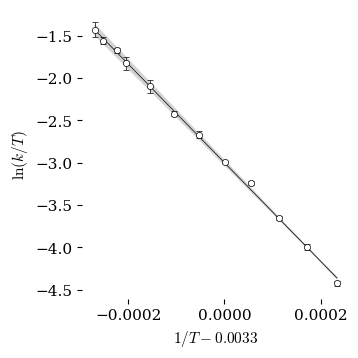

The slope is -5826.55 +/- 66.47
The intercept is -2.998 +/- 0.0116
The RSQ is 0.999


In [159]:
### Remove Lever Arm

### Choose our x and y values.

x = df["1/T"]-0.0033
y = unp.nominal_values(df["ln(k)/T"])
y_err = unp.std_devs(df["ln(k)/T"])

nstd = 2.     # Number of sigmas for confidence interval 1 = 68%, 2 = 95%, 3 = 99.7% confidence

### Curve fit to linear function

def linear(x, slope, intercept):
    return slope * x + intercept

poptL,pcovL = curve_fit(linear, x, y, 
          #             sigma = y_err, absolute_sigma=False  # Include st_devs for y data in calculations
                     )

[slopeL,interceptL] = poptL
perrL = np.sqrt(np.diag(pcovL))

### Create figure for plot
plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

size = [4,4]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=size)  

### Create plot #0 for plot

# Settings for plot
ax.set(
#          title = Title,       
          ylabel=r"$\ln (k / T)$", 
          xlabel=r"$1/T - 0.0033$",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
#          ylim=[None,None]
       )

# Plot the data
#ax.scatter(x, y, marker = "o", s = 70, color = "white", alpha = 1.0, zorder = 1)
ax.scatter(x, y, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3) 

# Add error bars
ax.errorbar(x, y, yerr=y_err, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
               capsize=2, capthick=0.5, zorder=2)

# Calculate the line from curve fit parameters
x_fit = np.linspace(np.min(x), np.max(x), 100)
#x_fit = np.linspace(0, np.max(x), 100)
y_fit = linear(x_fit,slopeL,interceptL)

# Plot the curve fit line
ax.plot(x_fit, y_fit, 
           marker = None, color = "black", 
           linewidth=0.5, zorder = 2)

# prepare confidence level curves
popt_plus = poptL + nstd * perrL    # add error to parameters
popt_minus = poptL - nstd * perrL   # subtract error from paramneters

# steeper slope will result in higher intercept and vice versa
confidence_line_1 = linear(x=x_fit, slope=popt_plus[0], intercept=popt_minus[1])
confidence_line_2 = linear(x=x_fit, slope=popt_minus[0], intercept=popt_plus[1])

# Plot confidence interval
ax.fill_between(x_fit, confidence_line_1, confidence_line_2, 
                   color="lightgray", alpha=1, zorder = 0,
                   label="confidence interval")


#ax.set_xticks([0.0032,0.0033,0.0034])

### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("Eyring_L.pdf")
plt.show()

print(f"The slope is {slopeL:0.2f} +/- {perrL[0]:0.2f}")
print(f"The intercept is {interceptL:0.3f} +/- {perrL[1]:0.4f}")

r, p = scipy.stats.pearsonr(x, y)
rsq = r ** 2

print(f"The RSQ is {rsq:0.3f}")



In [163]:
R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

slope_unc = un.ufloat(slopeL, perr[0])
dH = -slope_unc * R
print(f"The change in enthalpy is {dH:0.2f} kJ/mole")

intercept_unc = un.ufloat(interceptL, perrL[1])
intercept_unc = intercept_unc - slope_unc*0.0033

print(f"{intercept_unc:0.2f}")
dS = (intercept_unc - np.log(kb/h)) * R
print(f"The change in entropy is {dS:0.2f} J/mole.K")

## calculate k from Erying plot parameters.
Temp = 325
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)

print(f"{dH:.1f}")
print(f"{dS:0.2f}")
print(f"calculate k at T={Temp} K is {kobs:0.2f}")


The change in enthalpy is 48444.61+/-5965.99 kJ/mole
16.23+/-2.37
The change in entropy is -62.61+/-19.69 J/mole.K
48444.6+/-5966.0
-62.61+/-19.69
calculate k at T=325 K is 59.46+/-9.54


The slope is -5826.55 +/- 66.47
The intercept is 16.229 +/- 0.2158

The change in enthalpy is 48.44+/-0.55 kJ/mole
The change in entropy is -62.61+/-1.79 J/mole.K
calculate k at T=325 K is 59.46+/-17.68

In [164]:
R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

slope_unc = un.ufloat(slope, perr[0])
dH = -slope_unc * R
print(f"{slope_unc:0.4f}")

print(f"The change in enthalpy is {dH:0.2f} kJ/mole")

intercept_unc = un.ufloat(intercept, perr[1])
dS = (intercept_unc - np.log(kb/h)) * R
print(f"{intercept_unc:0.4f}")

print(f"The change in entropy is {dS:0.2f} J/mole.K")

## calculate k from Erying plot parameters.

Temp = 325

kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)

print(f"calculate k at T={Temp} K is {kobs:0.2f}")

-5857.8841+/-717.5437
The change in enthalpy is 48705.16+/-5965.99 kJ/mole
16.3402+/-2.3705
The change in entropy is -61.69+/-19.71 J/mole.K
calculate k at T=325 K is 60.32+/-195.41
